In [20]:
import os
import numpy as np
import re
import csv

import sys
sys.path.insert(0, '../..')
import metrics.charades_classify as cc
from datasets.prepare_dataset import load_labels_file

import matplotlib.pyplot as plt
from inspect import signature

from scipy import signal
from torch.nn import MaxPool1d

import torch

In [ ]:
dir_name = "/data/OnlineActionRecognition/final_outputs/"
files_dir =  "causal_eval_charades_r50i3d_pred_nl8_stream_centerCrop"

result_files = sorted([os.path.join(dir_name, files_dir, f) for f in os.listdir(dir_name + files_dir) if f.endswith('.txt')])

test_ids = []
test_classes = []
for fname in result_files:
    print(fname)
    ids, classes = cc.read_file(fname)
    test_ids += ids
    test_classes += classes
    print(len(test_ids), len(test_classes))

/data/OnlineActionRecognition/final_outputs/causal_eval_charades_r50i3d_pred_nl8_stream_centerCrop/causal_eval_charades_r50i3d_pred_nl8_stream_centerCrop_0.txt


In [43]:
# gt_path = '/data/Datasets/Charades/Annotations/Charades_v1_causal_clip_test.txt'
classes_file = '/data/Datasets/Charades/Annotations/Charades_v1_classes.txt'
classes_att_file = '/data/Datasets/Charades/Annotations/Charades_v1_attributes_class.csv'
classes_map_file = '/data/Datasets/Charades/Annotations/Charades_v1_mapping.txt'
# gt_path = '/data/Datasets/Charades/Annotations/Charades_v1_causal_allFrames_test.txt'
gt_path = '/data/Datasets/Charades/Annotations/Charades_v1_causal_test.txt'

per_frame = True

In [4]:
# Load classes
classes = load_labels_file(classes_file)

In [6]:
def divide_per_clip(ids, classes):
    clips_ids = []
    clips_classes = []

    video_name = None
    for i, video_frame in enumerate(ids):
        name = video_frame.split('_')[0]
        if name != video_name:
            # new video! But first, save old video
            if i > 0:
                clips_ids.append(np.array(video_ids))
                clips_classes.append(np.array(video_classes))
            # star new one
            video_ids = []
            video_classes = []
            video_name = name
            
        video_ids.append(video_frame)
        video_classes.append(classes[i])
        
    # Append last video
    clips_ids.append(np.array(video_ids))
    clips_classes.append(np.array(video_classes))
        
    return np.array(clips_ids), np.array(clips_classes)

In [118]:
gt_ids, gt_classes = cc.read_file(gt_path) 
gt_classes = np.array(gt_classes)

n_test = len(gt_ids)

# Check if there are duplicate items
test_ids2, test_index_order = np.unique(test_ids, return_index=True)
test_classes2 = np.array(test_classes)[test_index_order]

# Dividing per clip
gt_clips_ids, gt_clips_classes = divide_per_clip(gt_ids, gt_classes)
test_clips_ids, test_clips_classes = divide_per_clip(test_ids2, test_classes2)

In [90]:
def video_output(outputs):
    num_clips, num_classes = outputs.shape
    max_pool = MaxPool1d(num_clips)
    
    outputs = torch.tensor(outputs)

    data = outputs.view(1, -1, num_classes).contiguous()
    data = data.permute(0, 2, 1).contiguous()

    data = max_pool(data)
    video_data = data.view(num_classes).contiguous()

    return video_data

def select_n_clips(video_classes, n=10):
    num_frames = len(video_classes)
    ids = np.linspace(0, num_frames-1, n, dtype=int)
    
    return video_classes[ids]

In [126]:
def map_func(submission_array, gt_array):
    """ Returns mAP, weighted mAP, AP array, precisions, recall and calibrated AP"""
    m_aps = []
    c_aps = []
    fprs = []
    a_prec = np.zeros(submission_array.shape)
    a_recall = np.zeros(submission_array.shape)
    n_samples = submission_array.shape[0]
    n_classes = submission_array.shape[1]
    for oc_i in range(n_classes):
        sorted_idxs = np.argsort(-submission_array[:, oc_i])
        sorted_gt = gt_array[:, oc_i][sorted_idxs]
        tp = sorted_gt == 1
        fp = np.invert(tp)
        n_pos = tp.sum()
        n_gt = sorted_gt.sum()

        t_pcs = np.cumsum(tp)
        f_pcs = np.cumsum(fp)
        prec = t_pcs / (f_pcs+t_pcs).astype(float)
        recall = t_pcs / n_gt.astype(float)
        
        fpr = f_pcs / (n_samples - n_gt).astype(float)
        c_prec = recall / (recall + fpr)
        
        fprs.append(c_prec)
        # Calibrated prec
#         w = (n_samples - n_gt) / float(n_gt)
#         c_t_pcs = t_pcs * w
#         c_prec = c_t_pcs / (f_pcs + c_t_pcs).astype(float)

        avg_prec = 0
        c_avg_prec = 0
        for i in range(submission_array.shape[0]):
            if tp[i]:
                avg_prec += prec[i]
                c_avg_prec += c_prec[i]
        m_aps.append(avg_prec / n_pos.astype(float))
        c_aps.append(c_avg_prec / n_pos.astype(float))
        a_prec[:, oc_i] = prec
        a_recall[:, oc_i] = recall
    m_aps = np.array(m_aps)
    c_aps = np.array(c_aps)
    m_ap = np.nanmean(m_aps)
    c_ap = np.nanmean(c_aps)
    w_ap = np.nansum(m_aps * gt_array.sum(axis=0) / gt_array.sum().astype(float))
    return m_ap, w_ap, m_aps, a_prec, a_recall, c_ap, c_aps


def charades_map(submission_array, gt_array):
    """
    Approximate version of the charades evaluation function
    For precise numbers, use the submission file with the official matlab script
    """

    fix = submission_array.copy()
    empty = np.sum(gt_array, axis=1) == 0
    fix[empty, :] = np.NINF

    return map_func(fix, gt_array)

In [18]:
def get_perF_result(method='mean', delay_in_secs=3.0, secs_in_clip=3, frame=True):
    test_clips_classes_perF = []
    gt_clips_classes_perF = []
    num_classes = gt_clips_classes[0].shape[1]

    for v in range(gt_clips_ids.shape[0]):
        v_gt_ids = gt_clips_ids[v]
        v_gt_targets = gt_clips_classes[v]
        v_test_ids = test_clips_ids[v]
        v_test_targets = test_clips_classes[v]

        new_test_targets = []
        new_gt_targets = []

        clip_length = int(re.match('(.*)_(\d*)', v_test_ids[0]).groups()[-1]) +1 # in number of frames
        fps = float(clip_length/secs_in_clip)
        num_clips = int(fps * delay_in_secs) + 1
        num_frames = len(v_gt_ids)
        test_frames = len(v_test_targets)
        
        if num_clips > test_frames:
            continue

        # for gaussian
        norm_weights = signal.gaussian(clip_length, std=clip_length/4)
        middle = int(clip_length / 2)
        
        # for max_pool
        max_pool = MaxPool1d(num_clips)

        for f_id in range(num_frames):
            first_clip = f_id - clip_length + 1 
            if (first_clip + num_clips) < 0 or (first_clip + num_clips) > test_frames:
                continue
            new_gt_targets.append(v_gt_targets[f_id])
            
            first_clip = max(0, first_clip)
            last_clip = first_clip + num_clips
            clips_targets = v_test_targets[first_clip:last_clip]
            
            if method == 'gaussian':
                half = clips_targets.shape[0] / 2.0
                norm = norm_weights[middle-int(np.floor(half)):middle+int(np.ceil(half))]
                
                clips_targets = np.swapaxes(clips_targets, 0, 1)
                new_test_targets.append(np.average(clips_targets, axis=1, weights=norm))
                
            elif method == 'mean':
                new_test_targets.append(np.mean(clips_targets, axis=0))
                
            elif method == 'median':
                new_test_targets.append(np.median(clips_targets, axis=0))
                
            elif method == 'max_pool':
                outputs = torch.tensor(clips_targets)
                data = outputs.view(1, -1, num_classes).contiguous()
                data = data.permute(0, 2, 1).contiguous()
                
                data = max_pool(data)
                data = data.view(num_classes).contiguous().numpy()
                new_test_targets.append(data)
                

        test_clips_classes_perF.append(new_test_targets)
        gt_clips_classes_perF.append(new_gt_targets)
        
    if frame:
        test_clips_classes_perF = np.vstack(test_clips_classes_perF)
        gt_clips_classes_perF = np.vstack(gt_clips_classes_perF)

    return test_clips_classes_perF, gt_clips_classes_perF

In [19]:
# per frame using mean of all clips in the 'delay' period that have the frame

delays = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

mAP_mean = []
wAP_mean = []
cAP_mean = []
ap_mean = []
prec_mean = []
rec_mean = []

print('{} | {:6} | {:6}'.format('delay', 'mAP', 'cAP'))
for d in delays:
    test_targets_perF_mean, gt_targets_perF = get_perF_result('mean', delay_in_secs=d)

    m, w, ap, prec, rec, c = charades_map(test_targets_perF_mean, gt_targets_perF, w_array)
    mAP_mean.append(m)
    wAP_mean.append(w)
    ap_mean.append(ap)
    prec_mean.append(prec)
    rec_mean.append(rec)
    cAP_mean.append(c)
    print('{:4}s | {:4.2%} | {:4.2%}'.format(d, m, c))

delay | mAP    | cAP   


ValueError: not enough values to unpack (expected 6, got 5)

In [11]:
# Selecting only the classes with AP > t
selected_classes = {}

t = 0.1
for i, d in enumerate(delays):
    selected_ap = [a for a in ap_mean[i] if a >= t]
    selected_classes[t] = [j for j, a in enumerate(ap_mean[0]) if a >= t]
    print('{}s - {:.02%} mAP - {} classes'.format(d, np.mean(selected_ap), len(selected_ap)))

0.0s - 26.47% mAP - 96 classes
0.5s - 26.98% mAP - 99 classes
1.0s - 27.56% mAP - 99 classes
1.5s - 27.86% mAP - 100 classes
2.0s - 27.94% mAP - 102 classes
2.5s - 28.67% mAP - 100 classes
3.0s - 28.80% mAP - 101 classes


In [12]:
# per frame using median of all clips in the 'delay' period that have the frame

delays = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

mAP_median = []
wAP_median = []

print('{} | {:6} | {:6}'.format('delay', 'mAP', 'wAP'))
for d in delays:
    test_targets_perF_mean, gt_targets_perF = get_perF_result('median', delay_in_secs=d)

    m, w, _, _, _ = charades_map(test_targets_perF_mean, gt_targets_perF, w_array)
    mAP_median.append(m)
    wAP_median.append(w)
    print('{:4}s | {:4.2%} | {:4.2%}'.format(d, m, w))

delay | mAP    | wAP   
 0.0s | 18.07% | 28.42%
 0.5s | 18.73% | 29.24%
 1.0s | 19.11% | 29.72%
 1.5s | 19.37% | 30.08%
 2.0s | 19.60% | 30.39%
 2.5s | 19.77% | 30.66%
 3.0s | 19.91% | 30.89%


In [15]:
# per frame using gaussian of all clips in the 'delay' period that have the frame

delays = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

mAP_gauss = []
wAP_gauss = []

print('{} | {:6} | {:6}'.format('delay', 'mAP', 'wAP'))
for d in delays:
    test_targets_perF_mean, gt_targets_perF = get_perF_result('gaussian', delay_in_secs=d)

    m, w, _, _, _ = charades_map(test_targets_perF_mean, gt_targets_perF, w_array)
    mAP_gauss.append(m)
    wAP_gauss.append(w)
    print('{:4}s | {:4.2%} | {:4.2%}'.format(d, m, w))

delay | mAP    | wAP   
 0.0s | 18.07% | 28.42%
 0.5s | 18.83% | 29.37%
 1.0s | 19.26% | 29.90%
 1.5s | 19.58% | 30.33%
 2.0s | 19.85% | 30.70%
 2.5s | 20.03% | 30.98%


ValueError: Length of weights not compatible with specified axis.

In [16]:
# per frame using max_pooling of all clips in the 'delay' period that have the frame

delays = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

mAP_pool = []
wAP_pool = []

print('{} | {:6} | {:6}'.format('delay', 'mAP', 'wAP'))
for d in delays:
    test_targets_perF_mean, gt_targets_perF = get_perF_result('max_pool', delay_in_secs=d)

    m, w, _, _, _ = charades_map(test_targets_perF_mean, gt_targets_perF, w_array)
    mAP_pool.append(m)
    wAP_pool.append(w)
    print('{:4}s | {:4.2%} | {:4.2%}'.format(d, m, w))

delay | mAP    | wAP   
 0.5s | 18.77% | 29.21%
 1.0s | 19.24% | 29.77%
 1.5s | 19.68% | 30.30%
 2.0s | 20.06% | 30.78%
 2.5s | 20.38% | 31.20%
 3.0s | 20.60% | 31.50%


In [17]:
test_targets_perF_mean, gt_targets_perF_mean = get_perF_result('mean', delay_in_secs=3.0, frame=False)
test_targets_perF_lastF, gt_targets_perF_lastF = get_perF_result('mean', delay_in_secs=0.0, frame=False)

In [25]:
# per clip result using the N clip with mean of all frames

N = [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]

for n in N:

    test_classes_n = [select_n_clips(np.array(clip_data), n=n) for clip_data in test_targets_perF_mean]

    test_clip_n_mean = np.array([video_output(t_c).numpy() for t_c in test_classes_n])
    gt_clips_n_mean = np.array([(sum(gt_c) > 0).astype(int) for gt_c in gt_targets_perF_mean])

    mAP_n_mean, wAP_n_mean, _, _, _ = charades_map(test_clip_n_mean, gt_clips_n_mean, w_array)

    print('{:2} - {:.02%} | {:.02%}'.format(n, mAP_n_mean, wAP_n_mean))

 1 - 22.77% | 30.20%
 2 - 27.72% | 36.73%
 3 - 30.41% | 39.71%
 5 - 31.77% | 41.44%
10 - 32.55% | 42.05%
15 - 32.56% | 42.16%
20 - 32.52% | 42.09%
25 - 32.50% | 42.11%
30 - 32.54% | 42.15%
35 - 32.53% | 42.13%
40 - 32.51% | 42.11%
45 - 32.50% | 42.11%
50 - 32.52% | 42.12%
100 - 32.50% | 42.11%


In [22]:
# per clip result using the 10 clip with mean of all frames

test_classes_10 = [select_n_clips(np.array(clip_data), n=10) for clip_data in test_targets_perF_mean]

test_clip_10_mean = np.array([video_output(t_c).numpy() for t_c in test_classes_10])
gt_clips_10_mean = np.array([(sum(gt_c) > 0).astype(int) for gt_c in gt_targets_perF_mean])

mAP_10_mean, wAP_10_mean, ap_10_mean, prec_10_mean, recall_10_mean = charades_map(test_clip_10_mean, gt_clips_10_mean, w_array)

print(mAP_10_mean, wAP_10_mean)

0.32551438245507086 0.420526797886049


In [16]:
# per clip result using the 10 clip with lastFrame of all frames

test_classes_10 = [select_n_clips(np.array(clip_data), n=10) for clip_data in test_targets_perF_lastF]

test_clip_10_lastF = np.array([video_output(t_c).numpy() for t_c in test_classes_10])
gt_clips_10_lastF = np.array([(sum(gt_c) > 0).astype(int) for gt_c in gt_targets_perF_lastF])

mAP_10_lastF, wAP_10_lastF, ap_10_lastF, prec_10_lastF, recall_10_lastF = charades_map(test_clip_10_lastF, gt_clips_10_lastF, w_array)

print(mAP_10_lastF, wAP_10_lastF)

0.3157378085700365 0.4134088025846293


In [20]:
# per clip but using all per frame mean results

test_clip_all_perF_mean = np.array([video_output(np.array(t_c)).numpy() for t_c in test_targets_perF_mean])

mAP_cm, wAP_cm, ap_cm, prec_cm, recall_cm = charades_map(test_clip_all_perF_mean, gt_clips_10_mean, w_array)

print(mAP_cm, wAP_cm)

0.3250611782613844 0.42118410081599006


In [ ]:
## stop ##

In [35]:
prec_f.shape, recall_f.shape, prec.shape, recall.shape

((1153408, 157), (1153408, 157), (1863, 157), (1863, 157))

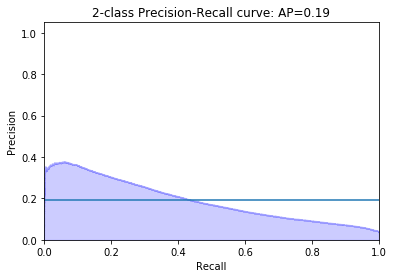

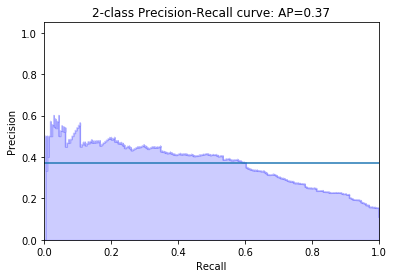

In [39]:
c = 6
plot_pr_curve(prec_f[:, c], recall_f[:, c], ap_f[c])
plot_pr_curve(prec[:, c], recall[:, c], ap[c])

In [65]:
np.sum((ap > 0.2).astype(int))

57

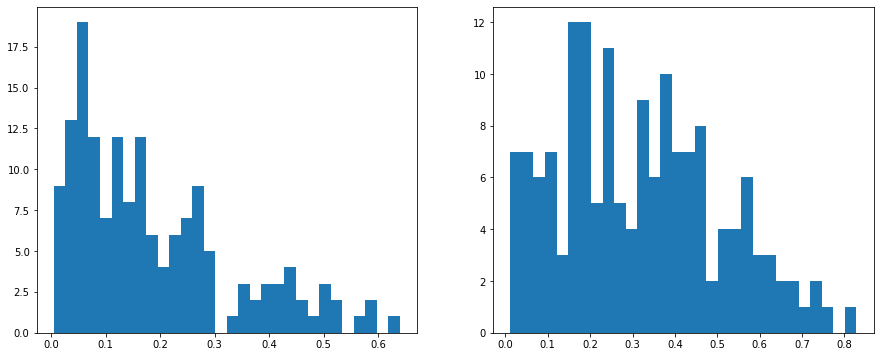

In [42]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(ap_f, bins=30)
ax2.hist(ap, bins=30)
plt.show()

In [49]:
for i, ap_i in enumerate(ap):
    print('{}: {:.02%} | {:.02%}'.format(i, ap_f[i], ap_i))

0: 27.35% | 44.35%
1: 28.29% | 50.34%
2: 27.73% | 45.39%
3: 16.21% | 30.98%
4: 18.83% | 29.45%
5: 17.26% | 27.86%
6: 19.01% | 37.31%
7: 2.52% | 4.69%
8: 27.29% | 56.94%
9: 16.69% | 39.54%
10: 5.17% | 8.86%
11: 58.50% | 73.26%
12: 28.72% | 40.30%
13: 7.97% | 17.50%
14: 37.04% | 45.49%
15: 42.81% | 57.30%
16: 41.58% | 59.01%
17: 2.92% | 11.06%
18: 7.19% | 19.52%
19: 21.71% | 23.74%
20: 32.37% | 47.15%
21: 26.11% | 46.83%
22: 6.20% | 17.52%
23: 5.62% | 14.79%
24: 0.88% | 2.81%
25: 12.46% | 35.99%
26: 49.57% | 62.62%
27: 16.99% | 43.41%
28: 8.36% | 19.87%
29: 11.67% | 24.28%
30: 8.27% | 27.58%
31: 0.76% | 2.08%
32: 46.21% | 62.34%
33: 20.17% | 32.32%
34: 10.24% | 20.03%
35: 9.47% | 19.54%
36: 3.08% | 8.46%
37: 15.24% | 17.41%
38: 19.97% | 26.48%
39: 6.80% | 20.27%
40: 20.44% | 37.12%
41: 11.10% | 24.18%
42: 6.40% | 19.67%
43: 11.98% | 31.31%
44: 6.36% | 11.11%
45: 0.57% | 1.17%
46: 5.60% | 18.05%
47: 38.73% | 56.34%
48: 5.09% | 14.43%
49: 12.29% | 31.56%
50: 3.73% | 14.87%
51: 49.27% | 57.

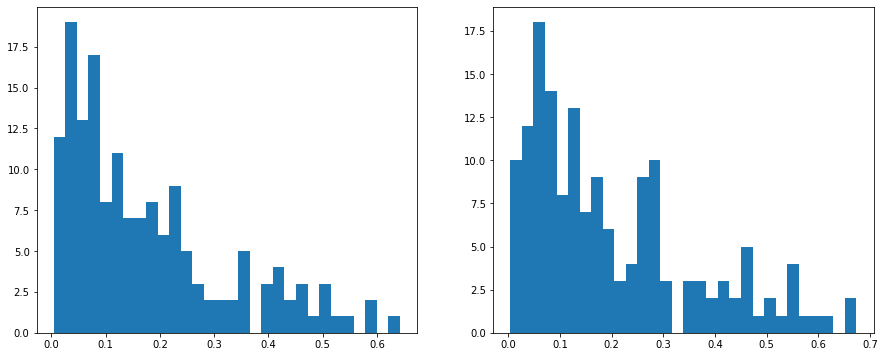

In [16]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(ap_mean[0], bins=30)
ax2.hist(ap_mean[-1], bins=30)
plt.show()

In [11]:
for i, ap_i in enumerate(ap_mean[-1]):
    print('{:6.2%} - {}: {}'.format(ap_i, i, classes[i]))

28.09% - 0: Holding some clothes
28.06% - 1: Putting clothes somewhere
28.98% - 2: Taking some clothes from somewhere
16.96% - 3: Throwing clothes somewhere
21.67% - 4: Tidying some clothes
18.71% - 5: Washing some clothes
16.53% - 6: Closing a door
 2.43% - 7: Fixing a door
29.01% - 8: Opening a door
13.90% - 9: Putting something on a table
 6.07% - 10: Sitting on a table
60.79% - 11: Sitting at a table
33.94% - 12: Tidying up a table
 9.55% - 13: Washing a table
39.47% - 14: Working at a table
46.36% - 15: Holding a phone/camera
45.80% - 16: Playing with a phone/camera
 2.27% - 17: Putting a phone/camera somewhere
 6.45% - 18: Taking a phone/camera from somewhere
26.19% - 19: Talking on a phone/camera
36.54% - 20: Holding a bag
28.75% - 21: Opening a bag
 5.83% - 22: Putting a bag somewhere
 5.20% - 23: Taking a bag from somewhere
 0.78% - 24: Throwing a bag somewhere
10.54% - 25: Closing a book
55.56% - 26: Holding a book
15.45% - 27: Opening a book
 8.26% - 28: Putting a book somew

In [10]:
class_atributes = {}
with open(classes_att_file, 'r') as csv_file:
    reader = csv.DictReader(csv_file)
    for row in reader:
        for column, value in row.items():
            class_match = re.match('c(\d*)', value)
            if class_match:
                value = int(class_match.groups()[0])
            else:
                value = float(value)
            class_atributes.setdefault(column, []).append(value)
            
class_atributes.keys()

dict_keys(['class', '#Samples', '#Frames', 'Extent', 'Seq', 'Short', 'Passive', 'AvgMotion', 'PoseVar', 'PoseRatio', 'Obj', '#Obj', '#Verbs', 'Interact', 'Tool'])

In [11]:
class_atributes['ap'] = ap_mean[-1]

In [12]:
atributes_array = [
    class_atributes['#Samples'],
    class_atributes['#Frames'], 
    class_atributes['Extent'], 
    class_atributes['Seq'],
    class_atributes['Passive'], 
    class_atributes['AvgMotion'],
    class_atributes['PoseVar'], 
    class_atributes['PoseRatio'], 
    class_atributes['#Obj'],
    class_atributes['#Verbs'],
    class_atributes['ap']
]

In [33]:
corr = np.corrcoef(atributes_array)

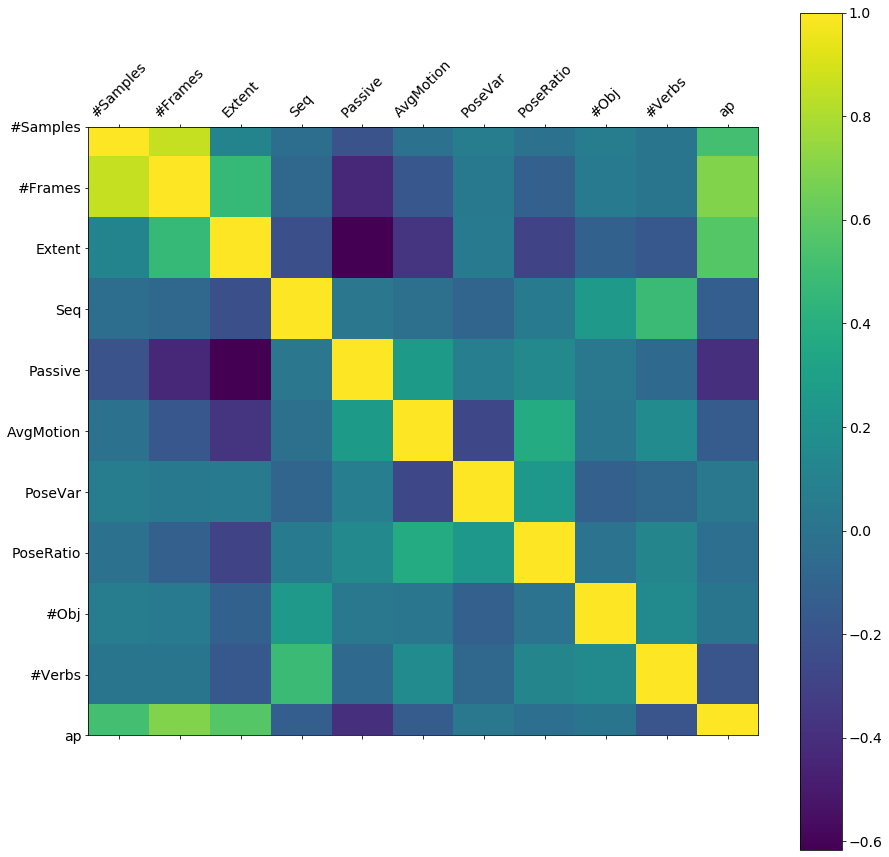

In [35]:
names = ['#Samples', '#Frames', 'Extent', 'Seq', 'Passive', 'AvgMotion', 'PoseVar', 'PoseRatio', '#Obj', '#Verbs', 'ap']

f = plt.figure(figsize=(15, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(len(names)), names, fontsize=14, rotation=45)
plt.yticks(range(len(names)), names, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [13]:
objs = []
verbs = []
with open(classes_map_file, 'r') as file:
    for line in file:
        match = re.match('c(\d*) o(\d*) v(\d*)', line)
        if match:
            c, o, v = match.groups()
            objs.append(int(o))
            verbs.append(int(v))

In [14]:
def load_map_file(file_path, letter):
    classes = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()

    for l in lines:
        class_match = re.match('{}(\d*) (.*)'.format(letter), l)
        if class_match:
            class_id, class_name = class_match.groups()
            classes[int(class_id)] = class_name
        else:
            raise ValueError('Could not match the line: \"{}\" from classes file!'.format(
                             l.strip()))
    return classes

In [15]:
objs_names = load_map_file('/data/Datasets/Charades/Annotations/Charades_v1_objectclasses.txt', 'o')
verbs_names = load_map_file('/data/Datasets/Charades/Annotations/Charades_v1_verbclasses.txt', 'v')

In [16]:
o_label, o_ind, o_count = np.unique(objs, return_index=True, return_counts=True)

In [17]:
objs_ap = [[] for i in range(max(objs) +1)]
verbs_ap = [[] for i in range(max(verbs) +1)]

for i, ap_i in enumerate(ap_mean[-1]):
    o = objs[i]
    v = verbs[i]
    objs_ap[o].append(ap_i)
    verbs_ap[v].append(ap_i)


In [86]:
# AP per object
ap_obj_mean = []
for i, l in enumerate(objs_ap):
    mean = np.mean(l)
    ap_obj_mean.append(mean)
    print('{:6.02%} : {}'.format(mean, objs_names[i]))

22.41% : None
15.42% : bag
36.58% : bed
17.51% : blanket
20.01% : book
 9.71% : box
29.14% : broom
30.90% : chair
14.65% : closet/cabinet
25.20% : clothes
24.70% : cup/glass/bottle
24.00% : dish
15.99% : door
14.35% : doorknob
36.54% : doorway
33.12% : floor
31.56% : food
12.35% : groceries
35.70% : hair
29.07% : hands
25.64% : laptop
 5.43% : light
 6.15% : medicine
 9.94% : mirror
18.22% : paper/notebook
22.96% : phone/camera
 5.11% : picture
12.75% : pillow
21.23% : refrigerator
14.49% : sandwich
14.22% : shelf
14.90% : shoe
43.40% : sofa/couch
27.29% : table
16.15% : television
14.19% : towel
20.82% : vacuum
10.88% : window


In [85]:
# AP per verb
ap_verb_mean = []
for i, l in enumerate(verbs_ap):
    mean = np.mean(l)
    ap_verb_mean.append(mean)
    print('{:6.02%} : {}'.format(mean, verbs_names[i]))

27.50% : awaken
 8.97% : close
67.11% : cook
26.76% : dress
54.35% : drink
25.31% : eat
10.97% : fix
25.54% : grasp
31.66% : hold
 6.60% : laugh
37.82% : lie
 8.83% : make
18.17% : open
10.69% : photograph
50.98% : play
 9.97% : pour
10.55% : put
40.80% : run
38.04% : sit
14.32% : smile
12.49% : sneeze
27.02% : snuggle
10.90% : stand
 9.63% : take
26.19% : talk
 4.12% : throw
31.49% : tidy
 5.15% : turn
22.69% : undress
36.54% : walk
18.78% : wash
28.97% : watch
38.19% : work


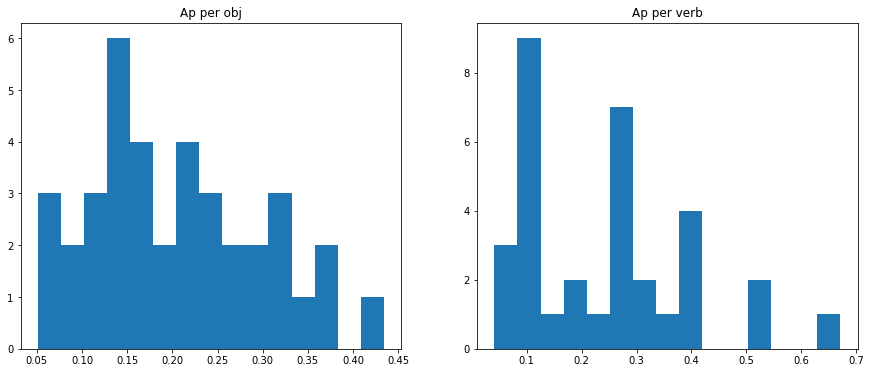

In [90]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(ap_obj_mean, bins=15)
ax1.set_title('Ap per obj')
ax2.hist(ap_verb_mean, bins=15)
ax2.set_title('Ap per verb')
plt.show()

In [92]:
# file_name = '/data/Datasets/Charades/Annotations/Charades_v1_classes_over_01.txt'
file_name = '/data/Datasets/Charades/Annotations/Charades_v1_classes_over_03.txt'

# t = 0.1
t = 0.3

with open(file_name, 'w') as file:
    for i, c in enumerate(selected_classes[t]):
        file.write('{} {} {}\n'.format(i, c, classes[c]))

In [16]:
print('{:3} | {:3} | {}'.format('0.1', '0.3', 'class'))
print('------------------')
for i, c in classes.items():
    print('{:3} | {:3} | {}'.format(
        'x' if i in selected_classes[0.1] else '', 
        'x' if i in selected_classes[0.3] else '', 
        c))

0.1 | 0.3 | class
------------------
x   |     | Holding some clothes
x   |     | Putting clothes somewhere
x   |     | Taking some clothes from somewhere
x   |     | Throwing clothes somewhere
x   |     | Tidying some clothes
x   |     | Washing some clothes
x   |     | Closing a door
    |     | Fixing a door
x   |     | Opening a door
x   |     | Putting something on a table
    |     | Sitting on a table
x   | x   | Sitting at a table
x   | x   | Tidying up a table
    |     | Washing a table
x   | x   | Working at a table
x   | x   | Holding a phone/camera
x   | x   | Playing with a phone/camera
    |     | Putting a phone/camera somewhere
    |     | Taking a phone/camera from somewhere
x   |     | Talking on a phone/camera
x   | x   | Holding a bag
x   |     | Opening a bag
    |     | Putting a bag somewhere
    |     | Taking a bag from somewhere
    |     | Throwing a bag somewhere
x   |     | Closing a book
x   | x   | Holding a book
x   |     | Opening a book
    |     | Pu

In [66]:
sample_array = np.array(class_atributes['#Samples'])
frame_array = np.array(class_atributes['#Frames'])

print('{:3} | {:8} | {:8} {:8} | {:10} {:4}'.format('', '#Classes', '#Samples', '%', '#Frames', '%'))
print('{:3} | {:8} | {:8} {:8} | {:10.2f} {:4}'.format(
    'All', len(class_atributes['#Samples']), sum(sample_array), '', sum(frame_array), ''))
print('{:3} | {:8} | {:8} ({:.2%}) | {:10.2f} ({:.2%})'.format(
    '0.1',
    len(sample_array[selected_classes[0.1]]), 
    sum(sample_array[selected_classes[0.1]]), sum(sample_array[selected_classes[0.1]])/sum(sample_array),
    sum(frame_array[selected_classes[0.1]]), sum(frame_array[selected_classes[0.1]])/sum(frame_array)))
print('{:3} | {:8} | {:8} ({:.2%}) | {:10.2f} ({:.2%})'.format(
    '0.3',
    len(sample_array[selected_classes[0.3]]), 
    sum(sample_array[selected_classes[0.3]]), sum(sample_array[selected_classes[0.3]])/sum(sample_array),
    sum(frame_array[selected_classes[0.3]]), sum(frame_array[selected_classes[0.3]])/sum(frame_array)))

    | #Classes | #Samples %        | #Frames    %   
All |      157 |  49809.0          |  643495.00     
0.1 |       92 |  40308.0 (80.93%) |  555642.30 (86.35%)
0.3 |       30 |  15804.0 (31.73%) |  281749.70 (43.78%)


In [93]:
for i, c in enumerate(classes):
    o = objs[i]
    v = verbs[i]
    print('{:45} | {:15} | {:10}'.format(classes[i], objs_names[o], verbs_names[v]))

Holding some clothes                          | clothes         | hold      
Putting clothes somewhere                     | clothes         | put       
Taking some clothes from somewhere            | clothes         | take      
Throwing clothes somewhere                    | clothes         | throw     
Tidying some clothes                          | clothes         | tidy      
Washing some clothes                          | clothes         | wash      
Closing a door                                | door            | close     
Fixing a door                                 | door            | fix       
Opening a door                                | door            | open      
Putting something on a table                  | table           | put       
Sitting on a table                            | table           | sit       
Sitting at a table                            | table           | sit       
Tidying up a table                            | table           | tidy      

In [94]:
file_name = '/data/Datasets/Charades/Annotations/Charades_v1_classes_by_verb.txt'

with open(file_name, 'w') as file:
    for i, c in enumerate(classes):
        v = verbs[i]
        file.write('{} {} {}\n'.format(i, v, verbs_names[v]))

In [99]:
class_to_verb = {}
with open(file_name, 'r') as file:
    for line in file:
        class_match = re.match('(\d*) (.*) (\d*)', line)
        if class_match:
            old_class_id, new_class_id, new_class_name = class_match.groups()
        class_to_verb[int(old_class_id)] = int(new_class_id)

In [33]:
# Compare pos_weight

frame_array = np.array(class_atributes['#Frames'])
total_frames = sum(frame_array)

per_class_pos_w = torch.FloatTensor([(total_frames-p)/p for p in frame_array])
torch.save(per_class_pos_w, '/data/Datasets/Charades/charades_pos_weight2.pt')

In [31]:
per_class_pos_w

tensor([  73.8929,   92.3372,  135.7480,  263.8237,  143.2620,  494.6443,
         146.4993, 1232.2216,  116.0523,   96.4904,  671.5491,   36.8393,
         194.8233, 1010.1486,  115.5287,   30.1982,   51.6032,  404.3767,
         264.3369,  138.1461,   58.5167,  223.3785,  297.3564,  283.8331,
        1143.8052,  581.5593,   54.8589,  259.5665,  330.3057,  525.2471,
         294.0053, 1737.2361,   73.9924,   68.3990,  276.3207,  297.0661,
         635.6195,  355.6848,  189.6991,  777.2017,  125.7146,  415.8254,
         377.9277,  411.7879,  407.3349, 2968.5200,  974.7316,  131.3356,
         873.9082,  985.8042,  958.8672,   93.5218,   92.8053,  196.1794,
         396.6118,  271.6789,  422.1293,  322.6734, 1099.7441,   22.1698,
         792.8502,   32.8468,  125.9246,   95.9586, 1491.3353,   92.8327,
        1153.4583,   85.7887,  578.9342,  501.7305,   81.2705,  341.5032,
         102.0317,  372.7990,  905.4587,  341.1572,   99.8423,  480.9826,
         243.4890,  529.4988,  684.152

In [24]:
pos_w = torch.load('/data/Datasets/Charades/charades_pos_weight.pt')

In [25]:
pos_w

tensor([  27.0113,   33.4677,   49.9477,   97.6062,   52.7059,  176.4791,
          54.9476,  432.8925,   43.2456,   34.3418,  242.4513,   12.5238,
          70.4935,  405.2042,   40.4424,   10.5810,   18.7631,  149.8074,
          96.1049,   50.4085,   20.8376,   80.5009,  108.3773,  103.9632,
         435.1042,  213.2371,   19.7877,   94.0198,  121.5721,  191.1769,
         109.8110,  666.2631,   26.5684,   25.5383,  102.9363,  111.4678,
         245.2827,  137.2398,   71.8954,  278.3262,   44.7165,  153.9107,
         134.8831,  147.9692,  148.4654, 1117.8147,  355.9427,   47.2803,
         329.6401,  361.2425,  359.1281,   33.8377,   32.7294,   70.0400,
         142.8881,   98.4205,  151.1845,  114.9891,  392.6926,    7.4400,
         274.6897,   11.2582,   45.2557,   34.8757,  561.3490,   32.3112,
         423.1969,   29.7527,  207.4127,  179.6216,   28.7536,  126.9901,
          35.8577,  137.7840,  335.2013,  132.1591,   36.8172,  185.3337,
          88.3986,  204.2657,  251.246

In [32]:
per_class_pos_w / pos_w

tensor([2.7356, 2.7590, 2.7178, 2.7029, 2.7181, 2.8028, 2.6662, 2.8465, 2.6836,
        2.8097, 2.7698, 2.9415, 2.7637, 2.4929, 2.8566, 2.8540, 2.7503, 2.6993,
        2.7505, 2.7405, 2.8082, 2.7749, 2.7437, 2.7301, 2.6288, 2.7273, 2.7724,
        2.7608, 2.7170, 2.7474, 2.6774, 2.6074, 2.7850, 2.6783, 2.6844, 2.6650,
        2.5914, 2.5917, 2.6385, 2.7924, 2.8114, 2.7017, 2.8019, 2.7829, 2.7436,
        2.6556, 2.7385, 2.7778, 2.6511, 2.7289, 2.6700, 2.7638, 2.8355, 2.8010,
        2.7757, 2.7604, 2.7921, 2.8061, 2.8005, 2.9798, 2.8863, 2.9176, 2.7825,
        2.7514, 2.6567, 2.8731, 2.7256, 2.8834, 2.7912, 2.7933, 2.8264, 2.6892,
        2.8455, 2.7057, 2.7012, 2.5814, 2.7118, 2.5952, 2.7544, 2.5922, 2.7230,
        2.7701, 2.7855, 2.7477, 2.7532, 2.5357, 2.7087, 2.6555, 2.7554, 2.6359,
        2.7226, 2.6859, 2.7107, 2.8243, 2.6461, 2.7158, 2.6403, 2.7789, 2.6661,
        2.6821, 2.7126, 2.7268, 2.6446, 2.7867, 2.6625, 2.7026, 2.7985, 2.8611,
        2.7964, 2.7278, 2.7722, 2.7999, 

In [41]:
by_verb_pos_frames = np.zeros((len(verbs_names)))
for i, c in enumerate(classes):
    v = verbs[i]
    class_frame_count = frame_array[i]
    by_verb_pos_frames[v] += class_frame_count
    
per_verb_pos_w = torch.FloatTensor([(total_frames-p)/p for p in by_verb_pos_frames])
torch.save(per_verb_pos_w, '/data/Datasets/Charades/charades_pos_weight_by_verb.pt')